# FairnessPP API Demonstration

This notebook demonstrates the FairnessPP API, a high-level wrapper for building fair machine learning models using Fairlearn.

## API Components
1. **ModelConfig**: Configuration dataclass for model hyperparameters
2. **EvaluationResult**: Comprehensive metrics dataclass
3. **FairnessPredictor**: Main wrapper class for training and evaluation
4. **Utility Functions**: Data loading and visualization

In [1]:
# Cell 1: Imports
from FairnessPP_utils import (
    ModelConfig,
    EvaluationResult,
    FairnessPredictor,
    load_chicago_data,
    plot_fairness_tradeoff,
    plot_group_metrics,
    create_comparison_table
)

print("FairnessPP API loaded successfully")
print("\nAvailable components:")
print("  - ModelConfig: Configuration dataclass")
print("  - EvaluationResult: Results dataclass")
print("  - FairnessPredictor: Main wrapper class")
print("  - load_chicago_data: Data loader with feature engineering")
print("  - plot_fairness_tradeoff: Visualization utility")
print("  - plot_group_metrics: Group-level visualization")
print("  - create_comparison_table: Comparison table generator")

FairnessPP API loaded successfully

Available components:
  - ModelConfig: Configuration dataclass
  - EvaluationResult: Results dataclass
  - FairnessPredictor: Main wrapper class
  - load_chicago_data: Data loader with feature engineering
  - plot_fairness_tradeoff: Visualization utility
  - plot_group_metrics: Group-level visualization
  - create_comparison_table: Comparison table generator


## 1. ModelConfig

Configuration dataclass for model hyperparameters.

In [2]:
# Cell 2: ModelConfig Examples
# Default configuration
default_config = ModelConfig()
print("Default Configuration:")
print(f"  n_estimators:        {default_config.n_estimators}")
print(f"  max_depth:           {default_config.max_depth}")
print(f"  learning_rate:       {default_config.learning_rate}")
print(f"  random_state:        {default_config.random_state}")
print(f"  max_iter_mitigation: {default_config.max_iter_mitigation}")
print(f"  constraint_type:     {default_config.constraint_type}")

# Custom configuration
custom_config = ModelConfig(
    n_estimators=150,
    max_depth=4,
    constraint_type="demographic_parity",
    max_iter_mitigation=75
)
print("\nCustom Configuration:")
print(f"  n_estimators:        {custom_config.n_estimators}")
print(f"  max_depth:           {custom_config.max_depth}")
print(f"  constraint_type:     {custom_config.constraint_type}")
print(f"  max_iter_mitigation: {custom_config.max_iter_mitigation}")

Default Configuration:
  n_estimators:        100
  max_depth:           5
  learning_rate:       0.1
  random_state:        42
  max_iter_mitigation: 50
  constraint_type:     equalized_odds

Custom Configuration:
  n_estimators:        150
  max_depth:           4
  constraint_type:     demographic_parity
  max_iter_mitigation: 75


## 2. FairnessPredictor

Main wrapper class with methods:
- `train()`: Train with optional fairness mitigation
- `predict()`: Generate predictions
- `predict_proba()`: Generate probability estimates
- `evaluate()`: Comprehensive evaluation

In [3]:
# Cell 3: Load Data for Demonstration
X, y, A, dates = load_chicago_data(use_enhanced_features=True)

# Temporal split
train_mask = dates.dt.year < 2023
X_train = X[train_mask]
y_train = y[train_mask]
A_train = A[train_mask]
X_test = X[~train_mask]
y_test = y[~train_mask]
A_test = A[~train_mask]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Fetching data from Chicago Open Data API...
  Fetching 2020...
  Fetching 2021...
  Fetching 2022...
  Fetching 2023...
Loaded 76722 records with 14 features
Arrest rate: 12.25%
Demographic groups: 20
Training samples: 57449
Test samples: 19273


In [4]:
# Cell 4: FairnessPredictor - Baseline Training
print("=" * 50)
print("Training Baseline Model (no mitigation)")
print("=" * 50)

config = ModelConfig(n_estimators=100, max_depth=5)
predictor = FairnessPredictor(config=config)

# Train without mitigation, with class balancing
predictor.train(
    X_train, y_train,
    mitigate=False,
    class_weight="balanced"
)

print("\nTraining complete!")

Training Baseline Model (no mitigation)
  Class weights: No Arrest=0.57, Arrest=4.09
Training Baseline Model (GradientBoosting)...
  Training predictions: 36740 negative, 20709 positive

Training complete!


In [5]:
# Cell 5: FairnessPredictor - Predictions
import numpy as np

# Generate predictions
predictions = predictor.predict(X_test)
print(f"Predictions shape: {predictions.shape}")
print(f"Prediction distribution: {np.bincount(predictions.astype(int))}")

# Generate probability estimates
probabilities = predictor.predict_proba(X_test)
if probabilities is not None:
    print(f"\nProbability estimates shape: {probabilities.shape}")
    print(f"Probability range: [{probabilities[:, 1].min():.3f}, {probabilities[:, 1].max():.3f}]")

Predictions shape: (19273,)
Prediction distribution: [12387  6886]

Probability estimates shape: (19273, 2)
Probability range: [0.007, 0.906]


In [6]:
# Cell 6: FairnessPredictor.evaluate() - Returns EvaluationResult
print("=" * 50)
print("FairnessPredictor.evaluate() -> EvaluationResult")
print("=" * 50)

result = predictor.evaluate(X_test, y_test, A_test)

print(f"\nReturned type: {type(result).__name__}")
print("\n" + "-" * 50)
print("Accessing EvaluationResult attributes:")
print("-" * 50)

print(f"\n1. Performance Metrics:")
print(f"   result.accuracy:          {result.accuracy:.3f}")
print(f"   result.balanced_accuracy: {result.balanced_accuracy:.3f}")
print(f"   result.precision:         {result.precision:.3f}")
print(f"   result.recall:            {result.recall:.3f}")
print(f"   result.f1_score:          {result.f1_score:.3f}")
print(f"   result.auc_roc:           {result.auc_roc:.3f}")

print(f"\n2. Fairness Metrics:")
print(f"   result.equalized_odds_diff:     {result.equalized_odds_diff:.3f}")
print(f"   result.demographic_parity_diff: {result.demographic_parity_diff:.3f}")
print(f"   result.fairness_disparity:      {result.fairness_disparity:.3f}")

print(f"\n3. Confusion Matrix:")
print(f"   result.confusion_matrix:")
print(f"   {result.confusion_matrix}")

FairnessPredictor.evaluate() -> EvaluationResult

Returned type: EvaluationResult

--------------------------------------------------
Accessing EvaluationResult attributes:
--------------------------------------------------

1. Performance Metrics:
   result.accuracy:          0.663
   result.balanced_accuracy: 0.629
   result.precision:         0.201
   result.recall:            0.584
   result.f1_score:          0.299
   result.auc_roc:           0.680

2. Fairness Metrics:
   result.equalized_odds_diff:     0.500
   result.demographic_parity_diff: 0.325
   result.fairness_disparity:      0.500

3. Confusion Matrix:
   result.confusion_matrix:
   [[11400  5500]
 [  987  1386]]


In [7]:
# Cell 7: EvaluationResult - Group-Level Attributes
from IPython.display import display

print("=" * 50)
print("EvaluationResult - Group-Level Attributes")
print("=" * 50)

print("\n1. result.group_metrics (DataFrame):")
print("   Contains per-group: Selection Rate, Accuracy, Precision, Recall, TPR, FPR, FNR")
display(result.group_metrics.round(3))

print("\n2. result.selection_rates (Series):")
print("   Positive prediction rate per demographic group")
print(result.selection_rates.round(3))

EvaluationResult - Group-Level Attributes

1. result.group_metrics (DataFrame):
   Contains per-group: Selection Rate, Accuracy, Precision, Recall, TPR, FPR, FNR


,Selection Rate,Accuracy,Precision,Recall,FPR,FNR,TPR
Intersectional_Group,,,,,,,
Asian_High,0.167,0.796,0.113,0.250,0.160,0.750,0.250
Asian_Low,0.329,0.689,0.209,0.573,0.296,0.427,0.573
Asian_Medium-High,0.325,0.676,0.175,0.509,0.302,0.491,0.509
Asian_Medium-Low,0.419,0.617,0.186,0.651,0.387,0.349,0.651
Black_High,0.293,0.707,0.212,0.500,0.264,0.500,0.500
Black_Low,0.426,0.604,0.177,0.625,0.399,0.375,0.625
Black_Medium-High,0.368,0.665,0.211,0.634,0.331,0.366,0.634
Black_Medium-Low,0.287,0.714,0.175,0.507,0.263,0.493,0.507
Hispanic_High,0.195,0.802,0.215,0.483,0.167,0.517,0.483



2. result.selection_rates (Series):
   Positive prediction rate per demographic group
Intersectional_Group
Asian_High              0.167
Asian_Low               0.329
Asian_Medium-High       0.325
Asian_Medium-Low        0.419
Black_High              0.293
Black_Low               0.426
Black_Medium-High       0.368
Black_Medium-Low        0.287
Hispanic_High           0.195
Hispanic_Low            0.447
Hispanic_Medium-High    0.289
Hispanic_Medium-Low     0.463
Other_High              0.492
Other_Low               0.230
Other_Medium-High       0.452
Other_Medium-Low        0.244
White_High              0.401
White_Low               0.356
White_Medium-High       0.276
White_Medium-Low        0.344
Name: Selection Rate, dtype: float64


## 3. Mitigation Strategies

FairnessPredictor supports two mitigation strategies:
- **In-processing**: ExponentiatedGradient applies fairness constraints during training
- **Post-processing**: ThresholdOptimizer adjusts thresholds after training

In [8]:
# Cell 8: In-Processing Mitigation (ExponentiatedGradient)
print("=" * 50)
print("In-Processing Mitigation (ExponentiatedGradient)")
print("=" * 50)
print("\nHow it works:")
print("  - Wraps base estimator (LogisticRegression)")
print("  - Iteratively reweights samples to satisfy fairness constraint")
print("  - Creates ensemble of predictors")

config_fair = ModelConfig(
    n_estimators=100,
    max_depth=5,
    max_iter_mitigation=50,
    constraint_type="equalized_odds"
)

fair_predictor = FairnessPredictor(config=config_fair)
fair_predictor.train(
    X_train, y_train, A=A_train,
    mitigate=True,
    mitigation_strategy="inprocessing",
    class_weight="balanced"
)

result_fair = fair_predictor.evaluate(X_test, y_test, A_test)

print(f"\nResults (EvaluationResult):")
print(f"  result_fair.balanced_accuracy:    {result_fair.balanced_accuracy:.3f}")
print(f"  result_fair.recall:               {result_fair.recall:.3f}")
print(f"  result_fair.equalized_odds_diff:  {result_fair.equalized_odds_diff:.3f}")

improvement = (result.equalized_odds_diff - result_fair.equalized_odds_diff) / result.equalized_odds_diff * 100
print(f"\nFairness Improvement: {improvement:.1f}%")

In-Processing Mitigation (ExponentiatedGradient)

How it works:
  - Wraps base estimator (LogisticRegression)
  - Iteratively reweights samples to satisfy fairness constraint
  - Creates ensemble of predictors
  Class weights: No Arrest=0.57, Arrest=4.09
Training Fair Model (In-Processing: ExponentiatedGradient)...
  Constraint: equalized_odds
  Trained ensemble of 6 predictors
  Training predictions: 5838 negative, 51611 positive

Results (EvaluationResult):
  result_fair.balanced_accuracy:    0.499
  result_fair.recall:               0.901
  result_fair.equalized_odds_diff:  0.132

Fairness Improvement: 73.6%


In [9]:
# Cell 9: Post-Processing Mitigation
print("=" * 50)
print("Post-Processing Mitigation (ThresholdOptimizer)")
print("=" * 50)

postproc_predictor = FairnessPredictor(config=config_fair)
postproc_predictor.train(
    X_train, y_train, A=A_train,
    mitigate=True,
    mitigation_strategy="postprocessing",
    class_weight="balanced"
)

result_postproc = postproc_predictor.evaluate(X_test, y_test, A_test)

print(f"\nPost-Processing Results:")
print(f"  Balanced Accuracy: {result_postproc.balanced_accuracy:.3f}")
print(f"  EO Disparity:      {result_postproc.equalized_odds_diff:.3f}")

Post-Processing Mitigation (ThresholdOptimizer)
  Class weights: No Arrest=0.57, Arrest=4.09
Training Fair Model (Post-Processing: ThresholdOptimizer)...
  Constraint: equalized_odds
  Step 1: Training base model with balanced class weights...
    Base model train preds: 36740 neg, 20709 pos
    Probability range: [0.008, 0.903]
  Step 2: Optimizing decision thresholds per group...
    Post-processed train preds: 30789 neg, 26660 pos

Post-Processing Results:
  Balanced Accuracy: 0.600
  EO Disparity:      0.180


## 4. Visualization Utilities

Model Comparison:


,Model,Accuracy,Balanced Acc,Precision,Recall,F1-Score,AUC-ROC,EO Disparity,DP Disparity
0,Baseline,0.663,0.629,0.201,0.584,0.299,0.680,0.500,0.325
1,Fair (In-Processing),0.196,0.499,0.123,0.901,0.216,0.000,0.132,0.067
2,Fair (Post-Processing),0.573,0.600,0.170,0.636,0.268,0.680,0.180,0.084


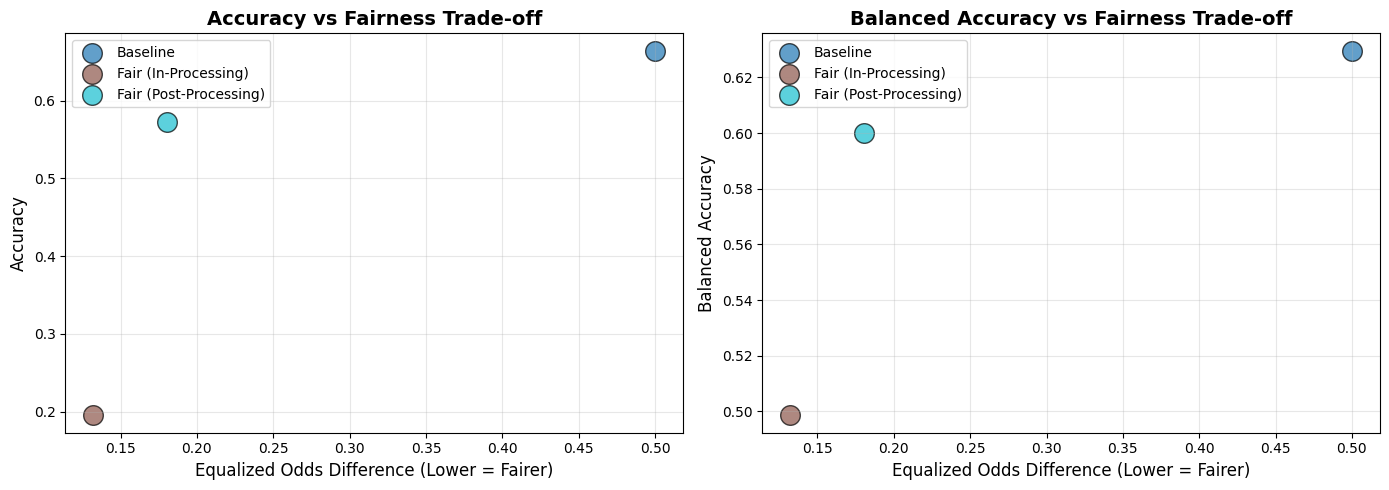

In [10]:
# Cell 10: Comparison Table and Plot
import matplotlib.pyplot as plt

results = {
    'Baseline': result,
    'Fair (In-Processing)': result_fair,
    'Fair (Post-Processing)': result_postproc
}

# Comparison table
comparison_df = create_comparison_table(results)
print("Model Comparison:")
display(comparison_df)

# Trade-off plot
fig = plot_fairness_tradeoff(results)
plt.show()

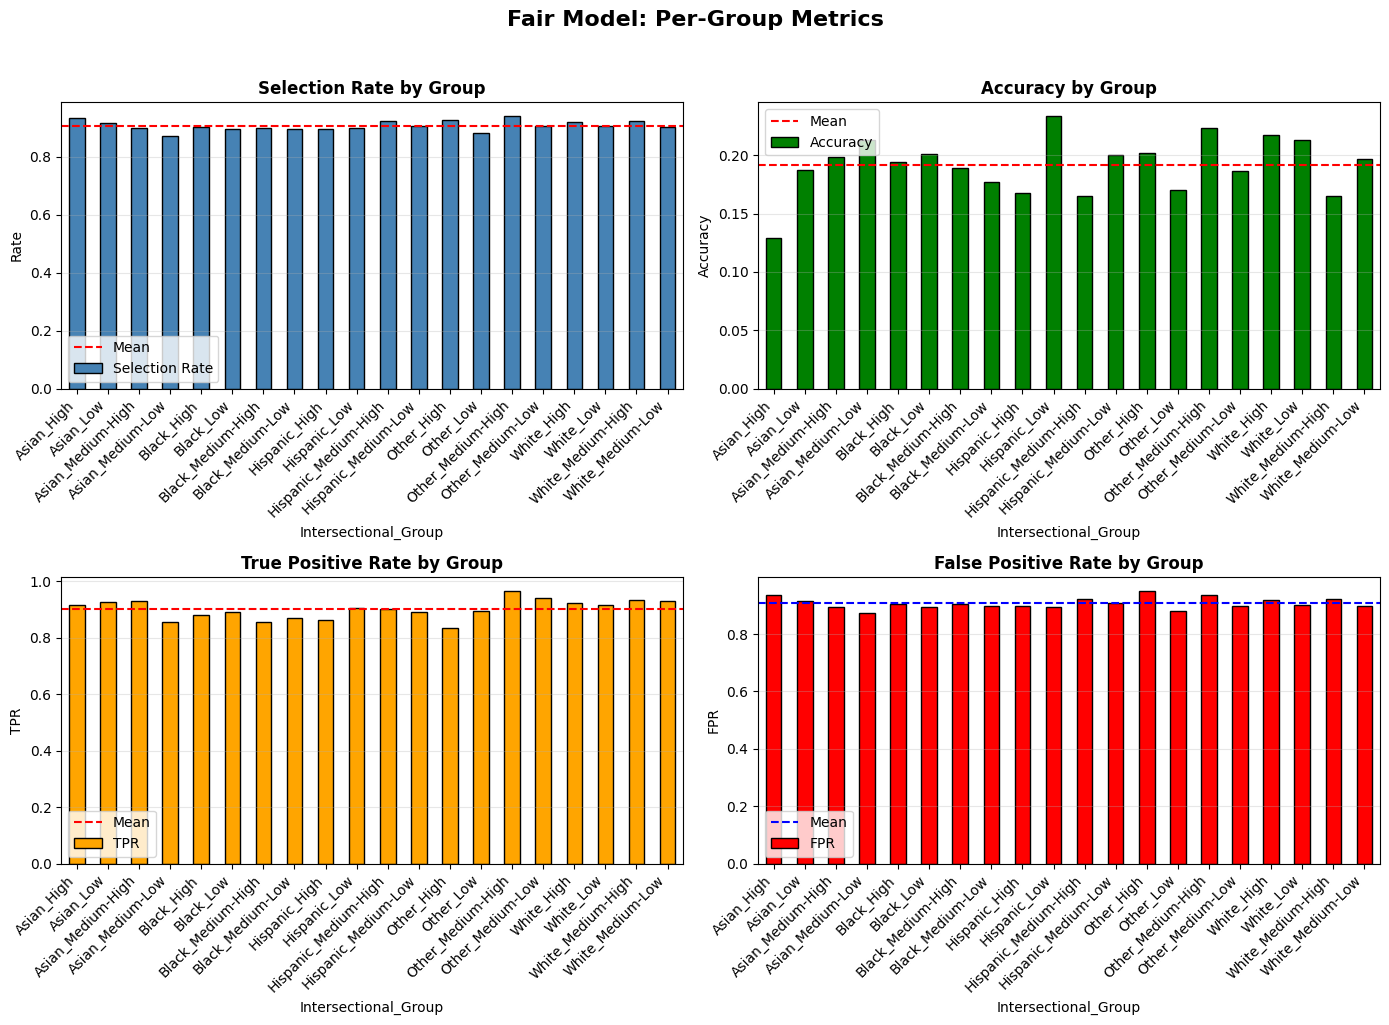

In [11]:
# Cell 11: Group Metrics Visualization
fig = plot_group_metrics(result_fair, title="Fair Model: Per-Group Metrics")

# 2. Iterate through each subplot to fix the labels
for ax in fig.axes:
    # ha='right' aligns the end of the label to the tick, preventing overlap
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# 3. Automatically adjust margins so labels don't get cut off
plt.tight_layout()

# 4. Show plot
plt.show()

## 5. API Summary

### Quick Reference

```python
# 1. Configure
config = ModelConfig(
    n_estimators=100,
    max_depth=5,
    constraint_type="equalized_odds"
)

# 2. Initialize
predictor = FairnessPredictor(config=config)

# 3. Train (with or without mitigation)
predictor.train(
    X_train, y_train, A=A_train,
    mitigate=True,
    mitigation_strategy="inprocessing",  # or "postprocessing"
    class_weight="balanced"
)

# 4. Evaluate
result = predictor.evaluate(X_test, y_test, A_test)

# 5. Access metrics
print(result.balanced_accuracy)
print(result.equalized_odds_diff)
print(result.group_metrics)
```